# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#Settings for the plots 
sns.set_style("ticks")
colors= sns.color_palette('colorblind')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=13)
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 6

sns.set_style("darkgrid", {'axes.grid' : False, 'ytick.left': True, 'xtick.bottom': True})

In [3]:
X_train = pd.read_csv("project-data-merged/df_X_train.csv", index_col=0)
y_train = pd.read_csv("project-data-merged/df_y_train.csv", index_col=0)

X_val = pd.read_csv("project-data-merged/df_X_val.csv", index_col=0)
y_val = pd.read_csv("project-data-merged/df_y_val.csv", index_col=0)

X_test = pd.read_csv("project-data-merged/df_X_test.csv", index_col=0)

# 1. Study the missing data

In [4]:
display(X_train)

,0.01,0.02,0.022,0.025,0.029,0.03,0.032,0.035,0.036,0.04,...,da5_75,da5_95,fiv3,magnitude,distance_closest,lowest_usable_frequency,sa_ratio,fiv3_ratio,is_pulselike,scale factor
0,0.045185,0.046608,0.046368,0.04686,0.049411,0.050919,0.050419,0.054394,0.054137,0.050810,...,5.32652,9.25004,0.752159,5.5,13.76,2.500,0.456032,0.179829,NO,227.966544
1,0.045185,0.046608,0.046368,0.04686,0.049411,0.050919,0.050419,0.054394,0.054137,0.050810,...,5.32652,9.25004,0.752159,5.5,13.76,2.500,0.456032,0.179829,NO,355.207497
2,0.045185,0.046608,0.046368,0.04686,0.049411,0.050919,0.050419,0.054394,0.054137,0.050810,...,5.32652,9.25004,0.752159,5.5,13.76,2.500,0.456032,0.179829,NO,491.118492
3,0.045185,0.046608,0.046368,0.04686,0.049411,0.050919,0.050419,0.054394,0.054137,0.050810,...,5.32652,9.25004,0.752159,5.5,13.76,2.500,0.456032,0.179829,NO,720.015093
4,0.045185,0.046608,0.046368,0.04686,0.049411,0.050919,0.050419,0.054394,0.054137,0.050810,...,5.32652,9.25004,0.752159,5.5,13.76,2.500,0.456032,0.179829,NO,980.160161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117131,0.007915,0.008107,NaN,NaN,0.008441,0.008701,0.009005,0.008805,0.008772,0.009389,...,11.32000,27.49000,1.069364,5.0,60.79,0.375,2.323039,0.290045,NO,30.514603
117132,0.007915,0.008107,NaN,NaN,0.008441,0.008701,0.009005,0.008805,0.008772,0.009389,...,11.32000,27.49000,1.069364,5.0,60.79,0.375,2.323039,0.290045,NO,93.197859
117133,0.007915,0.008107,NaN,NaN,0.008441,0.008701,0.009005,0.008805,0.008772,0.009389,...,11.32000,27.49000,1.069364,5.0,60.79,0.375,2.323039,0.290045,NO,133.039235
117134,0.007915,0.008107,NaN,NaN,0.008441,0.008701,0.009005,0.008805,0.008772,0.009389,...,11.32000,27.49000,1.069364,5.0,60.79,0.375,2.323039,0.290045,NO,49.865800


Rescale using the scaling factor all the scalable values (Sa(T), sa_avg, fiv3)

In [5]:
cols_to_be_changed = np.append(X_train.columns[:106].values,X_train.columns[108])
X_train[cols_to_be_changed] = X_train[cols_to_be_changed].mul(X_train['scale factor'], axis=0)
X_train = X_train.drop(columns = 'scale factor')

## 1.1. Randomly picked samples

<AxesSubplot:>

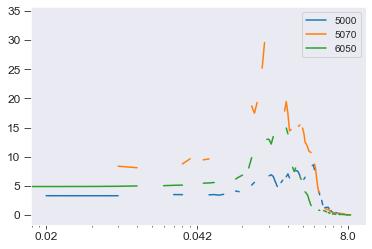

In [6]:
#X_plot = X_train.iloc[[4000,4015,5000,6000,7000],:105]
#check the different scales !! 
X_plot = X_train.iloc[[5000, 5070, 6050],:105]
#display(X_plot)
X_plot.T.plot(logx=True)

In [7]:
X_train.isnull().any()

0.01                        True
0.02                        True
0.022                       True
0.025                       True
0.029                       True
                           ...  
distance_closest           False
lowest_usable_frequency    False
sa_ratio                   False
fiv3_ratio                 False
is_pulselike               False
Length: 115, dtype: bool

We see that only the Sa(T) values have NaNs.

In [8]:
#Replacing the string column titles by their value in float: 
Sa_T_values = [float(x) for x in X_train.columns[:105]]
X_plot.columns = Sa_T_values


# 2. Interpolation of values using different methods

## 2.1. Interpolation method = 'linear'

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,3.299475,3.299475,3.294318,3.296878,3.321778,3.346679,3.420574,3.494469,3.484067,3.432916,...,0.090354,0.075934,0.061514,0.048606,0.037384,0.029558,0.025172,0.021543,0.017915,0.017915
5070,8.207758,8.207758,8.284363,8.360968,8.100641,8.344449,8.588257,8.673290,8.758323,9.634955,...,0.130995,0.095859,0.072810,0.049760,0.040178,0.034961,0.032014,0.029066,0.026670,0.024353
6050,4.987187,4.872964,4.886946,4.917360,4.974263,4.997757,5.021251,5.086068,5.118983,5.228604,...,0.037478,0.031882,0.026286,0.018093,0.014237,0.014030,0.011352,0.008675,0.007470,0.006573


<AxesSubplot:>

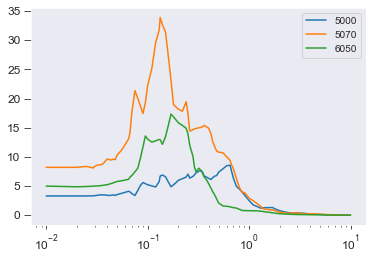

In [9]:
X_plot_interp_lin = X_plot.interpolate(method='linear', axis = 1, limit_direction='both')
display(X_plot_interp_lin)
X_plot_interp_lin.T.plot(logx=True)

We observe that if the first values where NaN, the method cannot guess the next number which logical as NaN is a "propagating variable".

To solve this problem, we can first have a look at the distribution of the values Sa(T=0.01)

The mean is: 6.335820620431721
The median is: 1.27698565373954


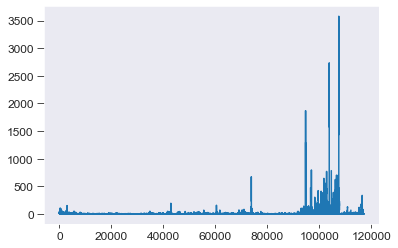

In [10]:
X_train['0.01'].plot()
print(f'The mean is: {X_train.iloc[:,0].mean()}')
print(f'The median is: {X_train.iloc[:,0].median()}')

We see that most of the values for Sa(T=0.01) in the DataSet are close to 0 with an average of `avg = 0.06` and a median of `med = 0.02`. 
Therefore, the most effective method would be to propagate backward the first value of Sa(T) encountered.
This can be done by simply adding: `limit_direction='both'` in the argument 

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,3.299475,3.299475,3.294318,3.296878,3.321778,3.346679,3.420574,3.494469,3.484067,3.432916,...,0.090354,0.075934,0.061514,0.048606,0.037384,0.029558,0.025172,0.021543,0.017915,0.017915
5070,8.207758,8.207758,8.284363,8.360968,8.100641,8.344449,8.588257,8.673290,8.758323,9.634955,...,0.130995,0.095859,0.072810,0.049760,0.040178,0.034961,0.032014,0.029066,0.026670,0.024353
6050,4.987187,4.872964,4.886946,4.917360,4.974263,4.997757,5.021251,5.086068,5.118983,5.228604,...,0.037478,0.031882,0.026286,0.018093,0.014237,0.014030,0.011352,0.008675,0.007470,0.006573


<AxesSubplot:>

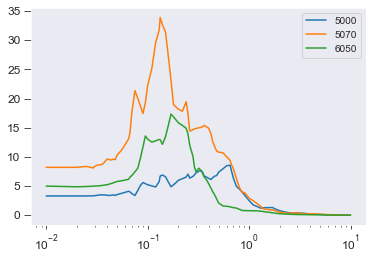

In [11]:
X_plot_interp_lin = X_plot.interpolate(method='linear', axis = 1, limit_direction='both')
display(X_plot_interp_lin)
X_plot_interp_lin.T.plot(logx=True)

## 2.2. Interpolation method = 'values'

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,3.299475,3.299475,3.294318,3.296878,3.336719,3.346679,3.405795,3.494469,3.484067,3.415866,...,0.090354,0.075934,0.061514,0.048606,0.037384,0.029558,0.025172,0.021543,0.017915,0.017915
5070,8.207758,8.207758,8.269042,8.360968,8.100641,8.263180,8.588257,8.715806,8.758323,9.634955,...,0.130995,0.095859,0.072810,0.049760,0.040178,0.034961,0.032014,0.029066,0.026670,0.024353
6050,4.987187,4.872964,4.886946,4.917360,4.974263,4.989926,5.021251,5.086068,5.118983,5.283414,...,0.037478,0.031882,0.026286,0.018093,0.014237,0.014030,0.011352,0.008675,0.007470,0.006573


<AxesSubplot:>

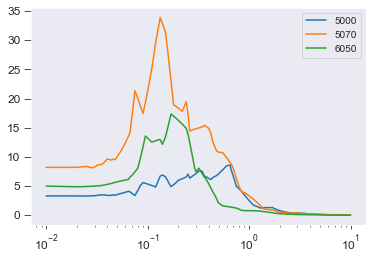

In [12]:
X_plot_interp_values = X_plot.interpolate(method = 'values', axis = 1, limit_direction='both')
display(X_plot_interp_values)
X_plot_interp_values.T.plot(logx=True)

In [13]:
X_plot_interp_values == X_plot_interp_lin

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,True,True,True,True,False,True,False,True,True,False,...,True,True,True,True,True,True,True,True,True,True
5070,True,True,False,True,True,False,True,False,True,True,...,True,True,True,True,True,True,True,True,True,True
6050,True,True,True,True,True,False,True,True,True,False,...,True,True,True,True,True,True,True,True,True,True


The "linear" and "values" methods yields approximately the same results. It is hard to define which one is the most efficient one though.For high period values, the results are exactly the same but they differ sligthly for smaller periods.

## 2.3. Interpolation method = 'quadratic'

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,NaN,3.299475,3.294318,3.296878,3.324550,3.346679,3.415960,3.494469,3.484067,3.394747,...,0.090354,0.073262,0.061514,0.048606,0.037384,0.029558,0.025172,0.021448,0.017915,NaN
5070,NaN,8.207758,8.380206,8.360968,8.100641,8.227011,8.588257,8.661568,8.758323,9.634955,...,0.130995,0.095859,0.068377,0.049760,0.040178,0.034961,0.031592,0.029066,0.026670,0.024353
6050,4.987187,4.872964,4.886946,4.917360,4.974263,4.989331,5.021251,5.086068,5.118983,5.279041,...,0.037478,0.027011,0.026286,0.018093,0.014237,0.014030,0.011632,0.008675,0.007470,0.006573


<AxesSubplot:>

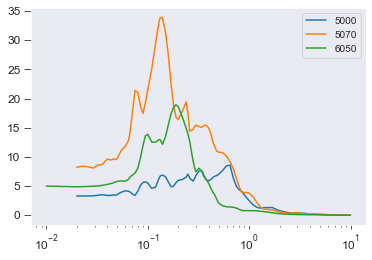

In [14]:
X_plot_interp_quad = X_plot.interpolate(method = 'quadratic', axis = 1, limit_direction='both')
display(X_plot_interp_quad)
X_plot_interp_quad.T.plot(logx=True)

## 2.4. Interpolation method = 'cubic'

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,NaN,3.299475,3.294318,3.296878,3.322648,3.346679,3.420663,3.494469,3.484067,3.400872,...,0.090354,0.073390,0.061514,0.048606,0.037384,0.029558,0.025172,0.022152,0.017915,NaN
5070,NaN,8.207758,8.570739,8.360968,8.100641,8.246273,8.588257,8.664872,8.758323,9.634955,...,0.130995,0.095859,0.068371,0.049760,0.040178,0.034961,0.031597,0.029066,0.026670,0.024353
6050,4.987187,4.872964,4.886946,4.917360,4.974263,4.989475,5.021251,5.086068,5.118983,5.282008,...,0.037478,0.026359,0.026286,0.018093,0.014237,0.014030,0.011675,0.008675,0.007470,0.006573


<AxesSubplot:>

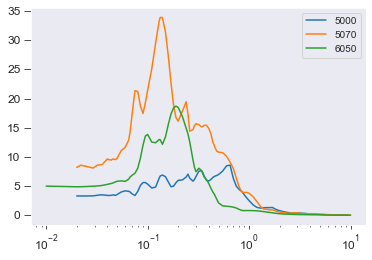

In [15]:
X_plot_interp_cub = X_plot.interpolate(method = 'cubic', axis = 1, limit_direction='both')
display(X_plot_interp_cub)
X_plot_interp_cub.T.plot(logx=True)

## 2.5 Interpolation method = 'piecewise_polynomial'

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,NaN,3.299475,3.294318,3.296878,3.322648,3.346679,3.420663,3.494469,3.484067,3.400872,...,0.090354,0.073390,0.061514,0.048606,0.037384,0.029558,0.025172,0.022152,0.017915,NaN
5070,NaN,8.207758,8.570739,8.360968,8.100641,8.246273,8.588257,8.664872,8.758323,9.634955,...,0.130995,0.095859,0.068371,0.049760,0.040178,0.034961,0.031597,0.029066,0.026670,0.024353
6050,4.987187,4.872964,4.886946,4.917360,4.974263,4.989475,5.021251,5.086068,5.118983,5.282008,...,0.037478,0.026359,0.026286,0.018093,0.014237,0.014030,0.011675,0.008675,0.007470,0.006573


<AxesSubplot:>

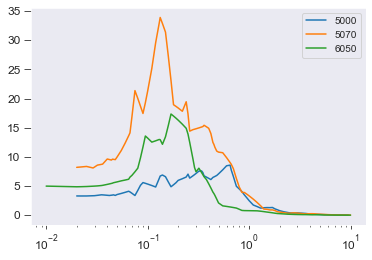

In [16]:
X_plot_interp_pwpol = X_plot.interpolate(method = 'piecewise_polynomial', axis = 1, limit_direction='both')
display(X_plot_interp_cub)
X_plot_interp_pwpol.T.plot(logx=True)

## 2.6 Interpolation method = 'spline'

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,NaN,3.299475,3.294318,3.296878,3.322648,3.346679,3.420663,3.494469,3.484067,3.400872,...,0.090354,0.073390,0.061514,0.048606,0.037384,0.029558,0.025172,0.022152,0.017915,NaN
5070,NaN,8.207758,8.570739,8.360968,8.100641,8.246273,8.588257,8.664872,8.758323,9.634955,...,0.130995,0.095859,0.068371,0.049760,0.040178,0.034961,0.031597,0.029066,0.026670,0.024353
6050,4.987187,4.872964,4.886946,4.917360,4.974263,4.989475,5.021251,5.086068,5.118983,5.282008,...,0.037478,0.026359,0.026286,0.018093,0.014237,0.014030,0.011675,0.008675,0.007470,0.006573


<AxesSubplot:>

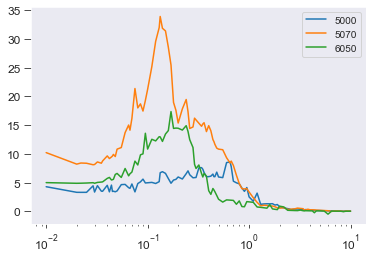

In [17]:
X_plot_interp_spl = X_plot.interpolate(method = 'spline', order=2, axis = 1, limit_direction='both')
display(X_plot_interp_cub)
X_plot_interp_spl.T.plot(logx=True)

## 2.7 Interpolation method = 'cubicspline'

,0.010,0.020,0.022,0.025,0.029,0.030,0.032,0.035,0.036,0.040,...,5.500,6.000,6.500,7.000,7.500,8.000,8.500,9.000,9.500,10.000
5000,NaN,3.299475,3.294318,3.296878,3.322648,3.346679,3.420663,3.494469,3.484067,3.400872,...,0.090354,0.073390,0.061514,0.048606,0.037384,0.029558,0.025172,0.022152,0.017915,NaN
5070,NaN,8.207758,8.570739,8.360968,8.100641,8.246273,8.588257,8.664872,8.758323,9.634955,...,0.130995,0.095859,0.068371,0.049760,0.040178,0.034961,0.031597,0.029066,0.026670,0.024353
6050,4.987187,4.872964,4.886946,4.917360,4.974263,4.989475,5.021251,5.086068,5.118983,5.282008,...,0.037478,0.026359,0.026286,0.018093,0.014237,0.014030,0.011675,0.008675,0.007470,0.006573


<AxesSubplot:>

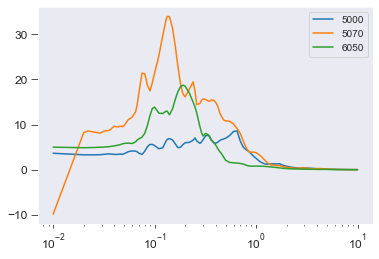

In [18]:
X_plot_interp_cubspl = X_plot.interpolate(method = 'cubicspline', axis = 1, limit_direction='both')
display(X_plot_interp_cub)
X_plot_interp_cubspl.T.plot(logx=True)

## 2.8 Deciding which method is the best

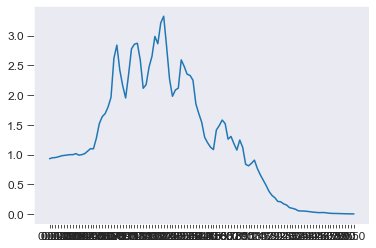

In [19]:
# Show Complete rows
plt.plot(X_train.iloc[400,:105])

(0.0, 1.0)

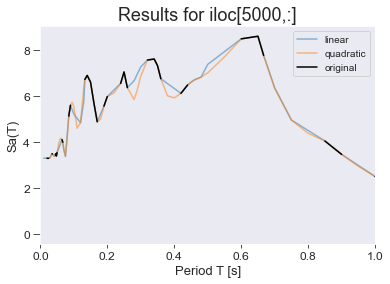

In [20]:
fig5000 = plt.figure(1)
plt.title('Results for iloc[5000,:]')
plt.plot(Sa_T_values, X_plot_interp_lin.iloc[0,:],  alpha=0.5, label = 'linear')
#plt.plot(Sa_T_values, X_plot_interp_values.iloc[0,:], c='green', alpha=0.5, label = 'values')
plt.plot(Sa_T_values, X_plot_interp_quad.iloc[0,:], alpha=0.5, label = 'quadratic')
#plt.plot(Sa_T_values, X_plot_interp_cub.iloc[0,:], alpha=0.5, label = 'cubic')
#plt.plot(Sa_T_values, X_plot_interp_pwpol.iloc[0,:], alpha=0.5, label = 'piecewise_polynomial')
#plt.plot(Sa_T_values, X_plot_interp_spl.iloc[0,:], alpha=0.5, label = 'spline, order=2')
#plt.plot(Sa_T_values, X_plot_interp_cubspl.iloc[0,:], alpha=0.5, label = 'cubicspline')
plt.plot(Sa_T_values, X_plot.iloc[0,:], c='black', alpha=1.0, label = 'original')

plt.legend(loc='best')
plt.xlabel('Period T [s]')
plt.ylabel('Sa(T)')
plt.xlim(0,1)

(0.0, 1.0)

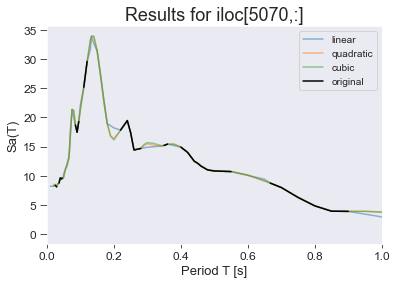

In [21]:
fig5070 = plt.figure(2)
plt.title('Results for iloc[5070,:]')
plt.plot(Sa_T_values, X_plot_interp_lin.iloc[1,:],  alpha=0.5, label = 'linear')
#plt.plot(Sa_T_values, X_plot_interp_values.iloc[1,:], c='green', alpha=0.5, label = 'values')
plt.plot(Sa_T_values, X_plot_interp_quad.iloc[1,:], alpha=0.5, label = 'quadratic')
plt.plot(Sa_T_values, X_plot_interp_cub.iloc[1,:], alpha=0.5, label = 'cubic')
#plt.plot(Sa_T_values, X_plot_interp_pwpol.iloc[1,:], alpha=0.5, label = 'piecewise_polynomial')
#plt.plot(Sa_T_values, X_plot_interp_spl.iloc[1,:], alpha=0.5, label = 'spline, order=2')
#plt.plot(Sa_T_values, X_plot_interp_cubspl.iloc[1,:], alpha=0.5, label = 'cubicspline')
plt.plot(Sa_T_values, X_plot.iloc[1,:], c='black', alpha=1.0, label = 'original')

plt.legend(loc='best')
plt.xlabel('Period T [s]')
plt.ylabel('Sa(T)')
plt.xlim(0,1)

Text(0, 0.5, 'Sa(T)')

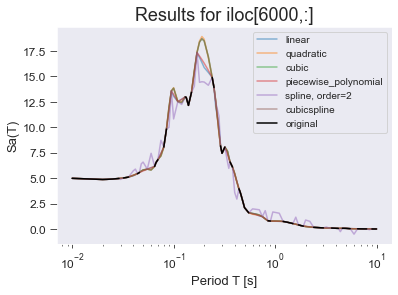

In [22]:
fig6000 = plt.figure(3)
plt.title('Results for iloc[6000,:]')
plt.semilogx(Sa_T_values, X_plot_interp_lin.iloc[2,:],  alpha=0.5, label = 'linear')
#plt.semilogx(Sa_T_values, X_plot_interp_values.iloc[2,:], c='green', alpha=0.5, label = 'values')
plt.semilogx(Sa_T_values, X_plot_interp_quad.iloc[2,:], alpha=0.5, label = 'quadratic')
plt.semilogx(Sa_T_values, X_plot_interp_cub.iloc[2,:], alpha=0.5, label = 'cubic')
plt.semilogx(Sa_T_values, X_plot_interp_pwpol.iloc[2,:], alpha=0.5, label = 'piecewise_polynomial')
plt.semilogx(Sa_T_values, X_plot_interp_spl.iloc[2,:], alpha=0.5, label = 'spline, order=2')
plt.semilogx(Sa_T_values, X_plot_interp_cubspl.iloc[2,:], alpha=0.5, label = 'cubicspline')
plt.semilogx(Sa_T_values, X_plot.iloc[2,:], c='black', alpha=1.0, label = 'original')

plt.legend(loc='best')
plt.xlabel('Period T [s]')
plt.ylabel('Sa(T)')
#plt.xlim(0,1)


## 2.9 Interpolating with method = 'quadratic'

In [23]:
X_train_Sa_T = X_train.iloc[:,:105]
X_train_Sa_T.columns=Sa_T_values
X_train_Sa_T_interp = X_train_Sa_T.interpolate(method = 'quadratic', axis = 1, limit_direction='both')

In [24]:
X_train_Sa_T_interp = X_train_Sa_T_interp.fillna(method = 'bfill')
#Chosen linear here instead of quadratic because quadratic cannot fill the first NaNs. So we need to fill backward afterwards...

In [25]:
X_train.iloc[:,:105] = X_train_Sa_T_interp
print(f'Checking if there remains any NaN. \nThere is: {np.sum(X_train.isnull().any(axis=0))} rows with NaNs. Ideally, there should remain 0.')

Checking if there remains any NaN. 
There is: 0 rows with NaNs. Ideally, there should remain 0.


In [26]:
X_train.to_csv('project-data-interpolated/df_X_train.csv')

# 3. Imputation using regression with sci-kit learn
On peut essayer der faire du ML avec les valeurs qu'on a qui sont complète. A voir cb de ligne on a qui sont complet

## 3.1 Create full dataset with the ones without any NaN

In [27]:
X_train = pd.read_csv("project-data-merged/df_X_train.csv", index_col=0)
y_train = pd.read_csv("project-data-merged/df_y_train.csv", index_col=0)

X_val = pd.read_csv("project-data-merged/df_X_val.csv", index_col=0)
y_val = pd.read_csv("project-data-merged/df_y_val.csv", index_col=0)

X_test = pd.read_csv("project-data-merged/df_X_test.csv", index_col=0)

In [28]:
cols_to_be_changed = np.append(X_train.columns[:106].values, X_train.columns[108])
X_train[cols_to_be_changed] = X_train[cols_to_be_changed].mul(X_train['scale factor'], axis=0)
X_train = X_train.drop(columns = 'scale factor')

X_val[cols_to_be_changed] = X_val[cols_to_be_changed].mul(X_val['scale factor'], axis=0)
X_val = X_val.drop(columns = 'scale factor')

In [29]:
display(X_train)

,0.01,0.02,0.022,0.025,0.029,0.03,0.032,0.035,0.036,0.04,...,sa_avg,da5_75,da5_95,fiv3,magnitude,distance_closest,lowest_usable_frequency,sa_ratio,fiv3_ratio,is_pulselike
0,10.300729,10.625048,10.570434,10.682532,11.264150,11.607873,11.493882,12.400047,12.341489,11.582892,...,0.971968,5.32652,9.25004,171.467182,5.5,13.76,2.500,0.456032,0.179829,NO
1,16.050146,16.555485,16.470388,16.645054,17.551305,18.086880,17.909263,19.321211,19.229969,18.047955,...,1.514478,5.32652,9.25004,267.172662,5.5,13.76,2.500,0.456032,0.179829,NO
2,22.191321,22.890014,22.772358,23.013855,24.266860,25.007358,24.761782,26.713974,26.587821,24.953540,...,2.093954,5.32652,9.25004,369.399397,5.5,13.76,2.500,0.456032,0.179829,NO
3,32.534075,33.558410,33.385917,33.739969,35.576965,36.662589,36.302556,39.164611,38.979661,36.583687,...,3.069888,5.32652,9.25004,541.566130,5.5,13.76,2.500,0.456032,0.179829,NO
4,44.288800,45.683232,45.448417,45.930390,48.431101,49.908966,49.418851,53.314981,53.063208,49.801557,...,4.179054,5.32652,9.25004,737.236692,5.5,13.76,2.500,0.456032,0.179829,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117131,0.241531,0.247383,NaN,NaN,0.257561,0.265518,0.274798,0.268693,0.267682,0.286502,...,0.114683,11.32000,27.49000,32.631219,5.0,60.79,0.375,2.323039,0.290045,NO
117132,0.737684,0.755559,NaN,NaN,0.786645,0.810945,0.839289,0.820643,0.817557,0.875035,...,0.350265,11.32000,27.49000,99.662439,5.0,60.79,0.375,2.323039,0.290045,NO
117133,1.053039,1.078555,NaN,NaN,1.122930,1.157618,1.198079,1.171462,1.167056,1.249106,...,0.500001,11.32000,27.49000,142.267375,5.0,60.79,0.375,2.323039,0.290045,NO
117134,0.394700,0.404264,NaN,NaN,0.420897,0.433899,0.449064,0.439088,0.437436,0.468190,...,0.187410,11.32000,27.49000,53.324693,5.0,60.79,0.375,2.323039,0.290045,NO


We already know that the NaN are only on the Sa(T) values. So we look for the rows without any NaN.


Get index of no NaN rows: 

In [30]:
#print(X_train.isnull().any(axis=1))
#print(np.sum(X_test.isnull().any(axis=1)))

In [31]:
full_rows_train = X_train.index[X_train.isnull().any(axis=1) == False].tolist()
full_rows_val = X_val.index[X_val.isnull().any(axis=1) == False].tolist()
#print(full_rows)
print(f'In the TRAINING set; there is: {np.shape(full_rows_train)[0]} full rows, which represents: {np.round(np.shape(full_rows_train)[0]/np.shape(X_train)[0] * 100,2)}% of the training set')
print(f'In the VALIDATING set; there is: {np.shape(full_rows_val)[0]} full rows, which represents: {np.round(np.shape(full_rows_val)[0]/np.shape(X_val)[0] * 100,2)}% of the validating set')
print(f'In TOTAL, we have: {np.shape(full_rows_val)[0] + np.shape(full_rows_val)[0]} full rows, which represents {np.round( (np.shape(full_rows_val)[0] + np.shape(full_rows_val)[0]) / (np.shape(X_train)[0] + np.shape(X_val)[0]) * 100,2)}% of the dataset, excluding the test data')
#print(f' type(full_rows) = {type(full_rows)}')
#print(f' type(full_rows[0]) = {type(full_rows[0])}')


In the TRAINING set; there is: 3431 full rows, which represents: 2.93% of the training set
In the VALIDATING set; there is: 2512 full rows, which represents: 100.0% of the validating set
In TOTAL, we have: 5024 full rows, which represents 4.2% of the dataset, excluding the test data


We see that we only have 4% of the dataset that is usable to train the regression which is not sufficient. Nonetheless, let's try to see the results. 

### Change is_pulse_like = NO to False

In [32]:
X_train.replace(['NO','YES'],[False,True],inplace=True)
X_val.replace(['NO','YES'],[False,True],inplace=True)

## 3.2 Start regression 

### Imports for sci-kit learn

In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

### Imputation

In [34]:
#Keep only the rows that are empty
empty_rows = X_train.index.to_list()
for ele in sorted(full_rows_train, reverse = True):
    del empty_rows[ele]

In [35]:
X_train.columns[X_train.eq(-999).any(axis=0) == True].to_list()

['magnitude', 'distance_closest', 'lowest_usable_frequency']

In [ ]:
X_test.columns[X_train.eq(-999).any(axis=0) == True].to_list()

In [35]:
#Values where there is corrupted data, i.e. a value of -999
X_values_corrupted = X_train.columns[X_train.eq(-999).any(axis=0) == True].to_list()
X_values_corrupted_validate = X_val.columns[X_train.eq(-999).any(axis=0) == True].to_list()

In [36]:
X_Values_training = X_train.iloc[full_rows_train,:].drop(columns = X_values_corrupted)
X_Values_missing = X_train.iloc[empty_rows,:].drop(columns = X_values_corrupted)
X_Values_all = X_train.drop(columns=X_values_corrupted)

X_Values_validate = X_val.drop(columns=X_values_corrupted_validate)
X_Values_train_val = pd.concat([X_Values_training, X_Values_validate], ignore_index=True)
X_Values_train_val_all = pd.concat([X_Values_all, X_Values_validate], ignore_index=True)

#display(X_Values_train_val)


In [37]:
#plt.plot(Sa_T_values ,X_Values_found[23,:105], color = 'blue', alpha = 0.5)
#plt.xlim(0,1)

## 3.3 Results

### 3.3.1 Using method = DecisionTreeRegressor

In [38]:
imp_DTR_train_val = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
imp_DTR_train = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
imp_DTR_val = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_val_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 

imp_DTR_train_val.fit(X_Values_train_val)
imp_DTR_train.fit(X_Values_training)
imp_DTR_val.fit(X_Values_validate)
#imp_DTR_train_all.fit(X_Values_all)
#imp_DTR_train_val_all.fit(X_Values_train_val_all)

#imp = IterativeImputer()


IterativeImputer(estimator=DecisionTreeRegressor(max_features='sqrt',
                                                 random_state=0),
                 random_state=0)

In [39]:
X_found_DTR_train_val = imp_DTR_train_val.transform(X_Values_missing)
X_found_DTR_train = imp_DTR_train.transform(X_Values_missing)
X_found_DTR_val = imp_DTR_val.transform(X_Values_missing)
#X_found_DTR_train_all = imp.transform(X_Values_missing)
#X_found_DTR_train_val_all = imp.transform(X_Values_missing)

#X_Values_found = imp.fit_transform(X_Values_all[:10000])

array([[False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True]])

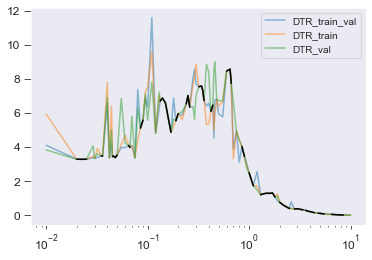

In [40]:
fig = plt.figure(1)

plt.semilogx(Sa_T_values ,X_found_DTR_train_val[4999-full_rows_train[-1],:105], alpha = 0.5, label='DTR_train_val') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_DTR_train[4999-full_rows_train[-1],:105], alpha = 0.5, label='DTR_train') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_DTR_val[4999-full_rows_train[-1],:105], alpha = 0.5, label='DTR_val') #for X_Values_missing

X_found_DTR_train_val == X_found_DTR_train
plt.semilogx(X_plot.T.iloc[:,0], color = 'black')

plt.legend(loc='best')

#plt.xlim(0,1)

X_found_DTR_train_val == X_found_DTR_train


### 3.3.2. Using method = BayesianRidge

In [41]:
imp_BR_train_val = IterativeImputer(estimator = BayesianRidge(), max_iter=10, random_state=0) 
imp_BR_train = IterativeImputer(estimator = BayesianRidge(), max_iter=10, random_state=0) 
imp_BR_val = IterativeImputer(estimator = BayesianRidge(), max_iter=10, random_state=0) 
#imp_DTR_train_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_val_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 

imp_BR_train_val.fit(X_Values_train_val)
imp_BR_train.fit(X_Values_training)
imp_BR_val.fit(X_Values_validate)
#imp_DTR_train_all.fit(X_Values_all)
#imp_DTR_train_val_all.fit(X_Values_train_val_all)

#imp = IterativeImputer()


IterativeImputer(estimator=BayesianRidge(), random_state=0)

In [42]:
X_found_BR_train_val = imp_BR_train_val.transform(X_Values_missing)
X_found_BR_train = imp_BR_train.transform(X_Values_missing)
X_found_BR_val = imp_BR_val.transform(X_Values_missing)
#X_found_DTR_train_all = imp.transform(X_Values_missing)
#X_found_DTR_train_val_all = imp.transform(X_Values_missing)

#X_Values_found = imp.fit_transform(X_Values_all[:10000])

array([[False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ...,
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True]])

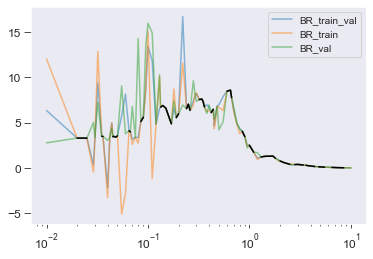

In [43]:
fig2 = plt.figure(2)

plt.semilogx(Sa_T_values ,X_found_BR_train_val[4999-full_rows_train[-1],:105], alpha = 0.5, label='BR_train_val') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_BR_train[4999-full_rows_train[-1],:105], alpha = 0.5, label='BR_train') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_BR_val[4999-full_rows_train[-1],:105], alpha = 0.5, label='BR_val') #for X_Values_missing

X_found_BR_train_val == X_found_BR_train
plt.semilogx(X_plot.T.iloc[:,0], color = 'black')

plt.legend(loc='best')

#plt.xlim(0,1)

X_found_BR_train_val == X_found_BR_train


### 3.3.3. Using method = ExtraTreesRegressor

### 3.3.4. Using method = KNeighborsRegressor

#### 3.3.4.1 n_neigbors = 2

In [44]:
imp_KN_train_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=2), max_iter=10, random_state=0) 
imp_KN_train = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 2), max_iter=10, random_state=0) 
imp_KN_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 2), max_iter=10, random_state=0) 
#imp_DTR_train_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_val_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 

imp_KN_train_val.fit(X_Values_train_val)
imp_KN_train.fit(X_Values_training)
imp_KN_val.fit(X_Values_validate)
#imp_DTR_train_all.fit(X_Values_all)
#imp_DTR_train_val_all.fit(X_Values_train_val_all)

#imp = IterativeImputer()


IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=2), random_state=0)

In [45]:
#X_found_KN_train_val = imp_KN_train_val.transform(X_Values_missing)
#X_found_KN_train = imp_KN_train.transform(X_Values_missing)
X_found_KN2_val = imp_KN_val.transform(X_Values_missing)
#X_found_DTR_train_all = imp.transform(X_Values_missing)
#X_found_DTR_train_val_all = imp.transform(X_Values_missing)

#X_Values_found = imp.fit_transform(X_Values_all[:10000])

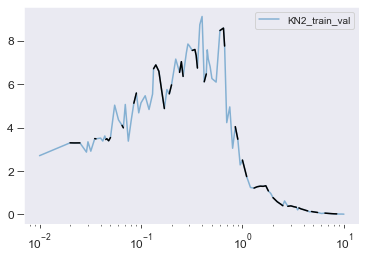

In [46]:
fig2 = plt.figure(2)

#plt.semilogx(Sa_T_values ,X_found_KN_train_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN2_train_val') #for X_Values_missing
#plt.semilogx(Sa_T_values ,X_found_KN_train[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN2_train_val') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_KN2_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN2_train_val') #for X_Values_missing


plt.semilogx(X_plot.T.iloc[:,0], color = 'black')

plt.legend(loc='best')

#plt.xlim(0,1)

#X_found_KN_train_val == X_found_KN_train

#### 3.3.4.2 n_neigbors = 3

In [47]:
imp_KN_train_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=3), max_iter=10, random_state=0) 
imp_KN_train = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 3), max_iter=10, random_state=0) 
imp_KN_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 3), max_iter=10, random_state=0) 
#imp_DTR_train_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_val_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 

imp_KN_train_val.fit(X_Values_train_val)
imp_KN_train.fit(X_Values_training)
imp_KN_val.fit(X_Values_validate)
#imp_DTR_train_all.fit(X_Values_all)
#imp_DTR_train_val_all.fit(X_Values_train_val_all)

#imp = IterativeImputer()


IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=3), random_state=0)

In [62]:
#X_found_KN_train_val = imp_KN_train_val.transform(X_Values_missing)
X_found_KN3_train = imp_KN_train.transform(X_Values_missing)
#X_found_KN3_val = imp_KN_val.transform(X_Values_missing)
#X_found_DTR_train_all = imp.transform(X_Values_missing)
#X_found_DTR_train_val_all = imp.transform(X_Values_missing)

#X_Values_found = imp.fit_transform(X_Values_all[:10000])

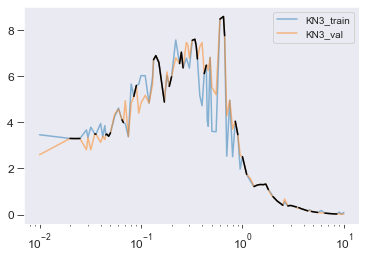

In [63]:
fig2 = plt.figure(2)

#plt.semilogx(Sa_T_values ,X_found_KN_train_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN3_train_val') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_KN3_train[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN3_train') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_KN3_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN3_val') #for X_Values_missing


plt.semilogx(X_plot.T.iloc[:,0], color = 'black')

plt.legend(loc='best')

#plt.xlim(0,1)

#X_found_KN_train_val == X_found_KN_train

#### 3.3.4.2 n_neigbors = 4

In [50]:
imp_KN_train_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=4), max_iter=10, random_state=0) 
imp_KN_train = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 4), max_iter=10, random_state=0) 
imp_KN_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 4), max_iter=10, random_state=0) 
#imp_DTR_train_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_val_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 

imp_KN_train_val.fit(X_Values_train_val)
imp_KN_train.fit(X_Values_training)
imp_KN_val.fit(X_Values_validate)
#imp_DTR_train_all.fit(X_Values_all)
#imp_DTR_train_val_all.fit(X_Values_train_val_all)

#imp = IterativeImputer()


IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=4), random_state=0)

In [51]:
#X_found_KN_train_val = imp_KN_train_val.transform(X_Values_missing)
#X_found_KN_train = imp_KN_train.transform(X_Values_missing)
X_found_KN4_val = imp_KN_val.transform(X_Values_missing)
#X_found_DTR_train_all = imp.transform(X_Values_missing)
#X_found_DTR_train_val_all = imp.transform(X_Values_missing)

#X_Values_found = imp.fit_transform(X_Values_all[:10000])

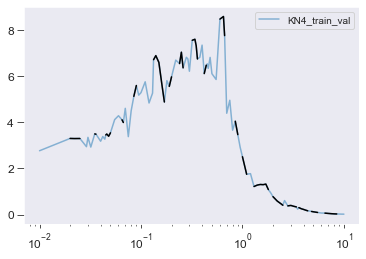

In [52]:
fig2 = plt.figure(2)

#plt.semilogx(Sa_T_values ,X_found_KN_train_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN4_train_val') #for X_Values_missing
#plt.semilogx(Sa_T_values ,X_found_KN_train[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN4_train_val') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_KN4_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN4_train_val') #for X_Values_missing


plt.semilogx(X_plot.T.iloc[:,0], color = 'black')

plt.legend(loc='best')

#plt.xlim(0,1)

#X_found_KN_train_val == X_found_KN_train

#### 3.3.4.2 n_neigbors = 5

In [53]:
imp_KN_train_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=5), max_iter=10, random_state=0) 
imp_KN_train = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 5), max_iter=10, random_state=0) 
imp_KN_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 5), max_iter=10, random_state=0) 
#imp_DTR_train_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_val_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 

imp_KN_train_val.fit(X_Values_train_val)
imp_KN_train.fit(X_Values_training)
imp_KN_val.fit(X_Values_validate)
#imp_DTR_train_all.fit(X_Values_all)
#imp_DTR_train_val_all.fit(X_Values_train_val_all)

#imp = IterativeImputer()


IterativeImputer(estimator=KNeighborsRegressor(), random_state=0)

In [54]:
#X_found_KN_train_val = imp_KN_train_val.transform(X_Values_missing)
#X_found_KN_train = imp_KN_train.transform(X_Values_missing)
X_found_KN5_val = imp_KN_val.transform(X_Values_missing)
#X_found_DTR_train_all = imp.transform(X_Values_missing)
#X_found_DTR_train_val_all = imp.transform(X_Values_missing)

#X_Values_found = imp.fit_transform(X_Values_all[:10000])

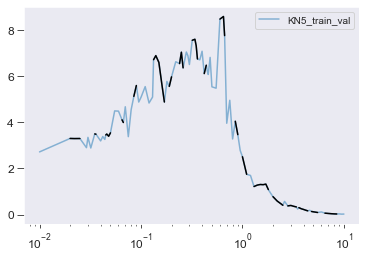

In [55]:
fig2 = plt.figure(2)

#plt.semilogx(Sa_T_values ,X_found_KN_train_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN5_train_val') #for X_Values_missing
#plt.semilogx(Sa_T_values ,X_found_KN_train[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN5_train_val') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_KN5_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN5_train_val') #for X_Values_missing


plt.semilogx(X_plot.T.iloc[:,0], color = 'black')

plt.legend(loc='best')

#plt.xlim(0,1)

#X_found_KN_train_val == X_found_KN_train

#### 3.3.4.2 n_neigbors = 6

In [56]:
imp_KN_train_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=6), max_iter=10, random_state=0) 
imp_KN_train = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 6), max_iter=10, random_state=0) 
imp_KN_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 6), max_iter=10, random_state=0) 
#imp_DTR_train_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_val_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 

imp_KN_train_val.fit(X_Values_train_val)
imp_KN_train.fit(X_Values_training)
imp_KN_val.fit(X_Values_validate)
#imp_DTR_train_all.fit(X_Values_all)
#imp_DTR_train_val_all.fit(X_Values_train_val_all)

#imp = IterativeImputer()


IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=6), random_state=0)

In [57]:
#X_found_KN_train_val = imp_KN_train_val.transform(X_Values_missing)
#X_found_KN_train = imp_KN_train.transform(X_Values_missing)
X_found_KN6_val = imp_KN_val.transform(X_Values_missing)
#X_found_DTR_train_all = imp.transform(X_Values_missing)
#X_found_DTR_train_val_all = imp.transform(X_Values_missing)

#X_Values_found = imp.fit_transform(X_Values_all[:10000])

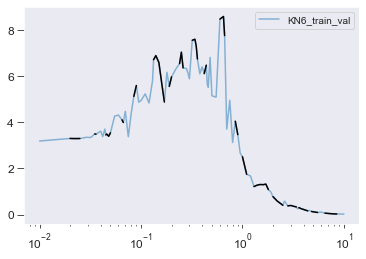

In [58]:
fig2 = plt.figure(2)

#plt.semilogx(Sa_T_values ,X_found_KN_train_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN6_train_val') #for X_Values_missing
#plt.semilogx(Sa_T_values ,X_found_KN_train[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN6_train_val') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_KN6_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN6_train_val') #for X_Values_missing


plt.semilogx(X_plot.T.iloc[:,0], color = 'black')

plt.legend(loc='best')

#plt.xlim(0,1)

#X_found_KN_train_val == X_found_KN_train

#### 3.3.4.2 n_neigbors = 7

In [59]:
imp_KN_train_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=7), max_iter=10, random_state=0) 
imp_KN_train = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 7), max_iter=10, random_state=0) 
imp_KN_val = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors = 7), max_iter=10, random_state=0) 
#imp_DTR_train_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 
#imp_DTR_train_val_all = IterativeImputer(estimator = DecisionTreeRegressor(max_features='sqrt', random_state=0), max_iter=10, random_state=0) 

imp_KN_train_val.fit(X_Values_train_val)
imp_KN_train.fit(X_Values_training)
imp_KN_val.fit(X_Values_validate)
#imp_DTR_train_all.fit(X_Values_all)
#imp_DTR_train_val_all.fit(X_Values_train_val_all)

#imp = IterativeImputer()


IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=7), random_state=0)

In [60]:
#X_found_KN_train_val = imp_KN_train_val.transform(X_Values_missing)
#X_found_KN_train = imp_KN_train.transform(X_Values_missing)
X_found_KN7_val = imp_KN_val.transform(X_Values_missing)
#X_found_DTR_train_all = imp.transform(X_Values_missing)
#X_found_DTR_train_val_all = imp.transform(X_Values_missing)

#X_Values_found = imp.fit_transform(X_Values_all[:10000])

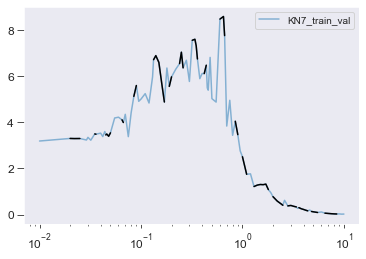

In [61]:
fig2 = plt.figure(2)

#plt.semilogx(Sa_T_values ,X_found_KN_train_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN7_train_val') #for X_Values_missing
#plt.semilogx(Sa_T_values ,X_found_KN_train[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN7_train_val') #for X_Values_missing
plt.semilogx(Sa_T_values ,X_found_KN7_val[4999-full_rows_train[-1],:105], alpha = 0.5, label = 'KN7_train_val') #for X_Values_missing


plt.semilogx(X_plot.T.iloc[:,0], color = 'black')

plt.legend(loc='best')

#plt.xlim(0,1)

#X_found_KN_train_val == X_found_KN_train